In [37]:
#scientific libraries and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

#torch specific
import torch
import torchvision as torchv
import torch.optim as optim

#other libraries
import time
import sys
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#Using newest versions of all libraries

In [38]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from resnet import *
from imcal import *
from imcal import CalorimeterDataset
from imcal import Hdf5Dataset
from imcal import RandomRoll
from imcal import plot_conf_matrix

In [39]:
#variables controlled by the user. Change these to fit your specific needs.
TRAIN_N_EVENTS = 10000 #Number of events to process for each class. If higher than the available number of events an exception will be raised.
TEST_N_EVENTS = 3000 #Number of events to process for each class. If higher than the available number of events an exception will be raised.
RES = 50 #resolution

#Data specification
LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n2_M12", "BH_n6_M8"] #for plotting
TEST_LABELS = [f"{label}_test" for label in LABELS]
PLOT_LABELS = ["SPH_9TeV", "BH_n2_M12", "BH_n6_M8"]
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
#"PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL"

FOLDERS = ["sph", "BH", "BH"]

TRAIN_FILENAMES = [f"{label}_res{RES}_10000_events.h5" for label in LABELS]
TEST_FILENAMES = [f"{label}_res{RES}_3000_events.h5" for label in TEST_LABELS]
TRAIN_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TRAIN_FILENAMES[i]}" for i in range(CLASSES)] #The path to the folder containing the training histogram files
TEST_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TEST_FILENAMES[i]}" for i in range(CLASSES)] #The path to the folder containing the testing histogram files

MODEL_NAME = f'resnet_{str(int(time.time()))}' #A unique name for the model
print(MODEL_NAME)

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    torch.cuda.empty_cache()
    print("Running on the GPU")
else:
    DEVICE = torch.device("cpu")
    print("Running on the CPU")

#Data processing
#filters=["saturate", "normalise"]
filters=None
transforms = torch.nn.Sequential(
        torchv.transforms.RandomVerticalFlip(),
        RandomRoll(roll_axis=0)
    )
#transforms=None

resnet_1670233839
Running on the GPU


In [40]:
#load data in memory
"""
trainpaths = [Path(TRAIN_DATAPATH/file) for file in TRAIN_FILENAMES]
testpaths = [Path(TEST_DATAPATH/file) for file in TEST_FILENAMES]
train_data = load_datasets(trainpaths, DEVICE, TRAIN_N_EVENTS, filters, transforms)
test_data = load_datasets(testpaths, DEVICE, TEST_N_EVENTS, filters, transforms)"""

#load data lazily to not run out of memory, no method to load only part of the data yet
testpaths = [Path(path) for path in TEST_DATAPATHS]
print(testpaths)

test_data = Hdf5Dataset(testpaths, TEST_LABELS, DEVICE, 
                        shuffle=False, filters=filters, transform=None, event_limit=TEST_N_EVENTS)

trainpaths = [Path(path) for path in TRAIN_DATAPATHS]
print(trainpaths)

train_data = load_datasets(trainpaths, DEVICE, TRAIN_N_EVENTS, filters, transforms)
#train_data = Hdf5Dataset(trainpaths, ["BH_n5_M8", "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL"], DEVICE, 
                    #shuffle=True, transform=transforms, event_limit=TRAIN_N_EVENTS)

#print(torch.cuda.memory_summary(DEVICE=None, abbreviated=False))

[PosixPath('/disk/atlas3/data_MC/2dhistograms/sph/50/PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_test_res50_3000_events.h5'), PosixPath('/disk/atlas3/data_MC/2dhistograms/BH/50/BH_n2_M12_test_res50_3000_events.h5'), PosixPath('/disk/atlas3/data_MC/2dhistograms/BH/50/BH_n6_M8_test_res50_3000_events.h5')]
[PosixPath('/disk/atlas3/data_MC/2dhistograms/sph/50/PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res50_10000_events.h5'), PosixPath('/disk/atlas3/data_MC/2dhistograms/BH/50/BH_n2_M12_res50_10000_events.h5'), PosixPath('/disk/atlas3/data_MC/2dhistograms/BH/50/BH_n6_M8_res50_10000_events.h5')]
Loads data with transforms Sequential(
  (0): RandomVerticalFlip(p=0.5)
  (1): RandomRoll()
) and filters None
Loaded data with 10000 entries of shape (10000, 50, 50, 3).
Check max value: 13608.056640625.
Loaded data with 10000 entries of shape (10000, 50, 50, 3).
Check max value: 20143.6171875.
Loaded data with 10000 entries of shape (10000, 50, 50, 3).
Check max value: 26033.96875.
Data has shape torch.Size

[['SPH_9TeV', 'SPH_9TeV', 'SPH_9TeV', 'SPH_9TeV'], ['BH_n2_M12', 'BH_n2_M12', 'BH_n2_M12', 'BH_n2_M12'], ['BH_n6_M8', 'BH_n6_M8', 'BH_n6_M8', 'BH_n6_M8']]
[[0, 0, 0, 0], [1, 1, 1, 1], [2, 2, 2, 2]]
[[34, 90, 72, 42], [3006, 3032, 3063, 3055], [6063, 6059, 6075, 6090]]
Image shape:  (50, 50, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

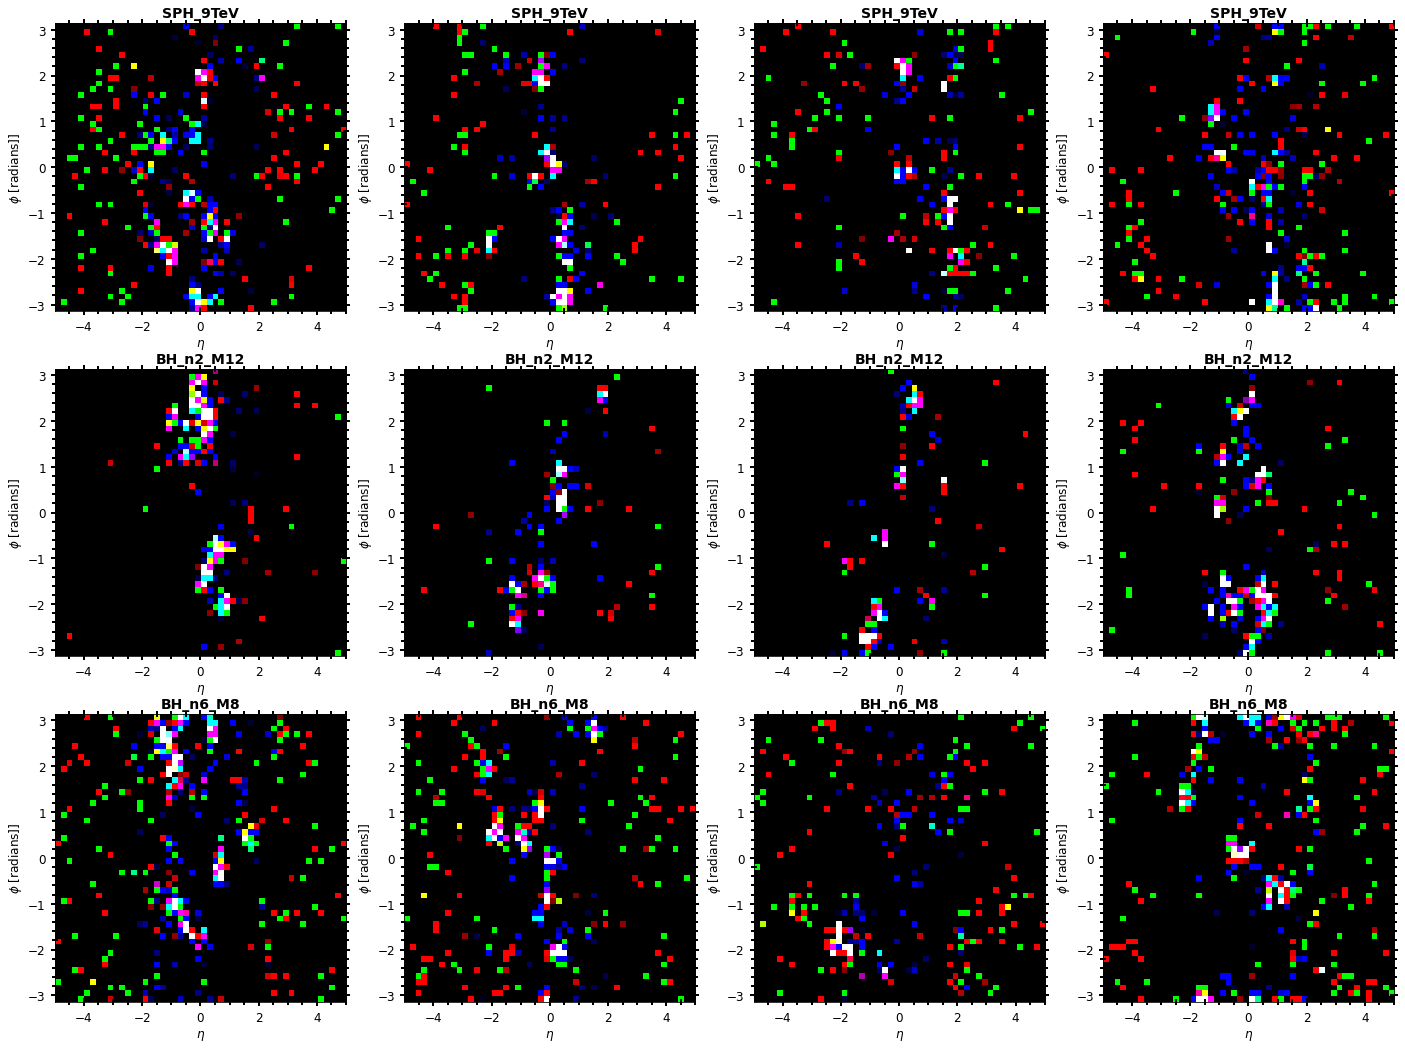

In [41]:
view_data(test_data, 4, CLASSES, PLOT_LABELS, RES, TEST_N_EVENTS)

Look at the highest histogram values values for a random image
[ 346.98132  377.1469   715.5309   748.9966   842.914   1021.74805
 1060.2792  1330.6427  1347.3326 ]
Looking at image 20166


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


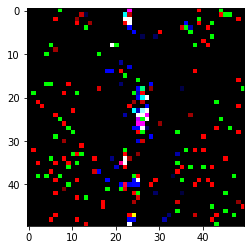

In [42]:
k = np.random.randint(0, len(train_data))
image = train_data[k][0].cpu()
print("Look at the highest histogram values values for a random image")
print(np.sort(image.flatten())[-10:-1])
print("Looking at image", k)

plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


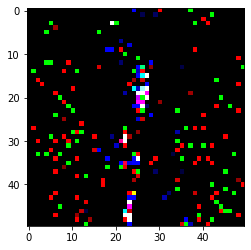

In [43]:
#Check augmentation

if transforms!=None:
    rolled_image = transforms(image)
    plt.imshow(rolled_image)

### Create net and train

In [44]:
#create NN and test that nothing major is wrong.
from resnet import ResNet18
resnet = ResNet18(img_channels=3, num_classes=CLASSES)
resnet.to(DEVICE)

#testimage, testlabel = traindata.images[0], traindata.img_labels[0]
testimage, testlabel = train_data[0][0], train_data[0][1]
print(testimage.view(-1, 3, RES, RES).shape)
print(resnet(testimage.view(-1, 3, RES, RES).to(DEVICE)))

torch.Size([1, 3, 50, 50])
tensor([[-0.1083, -0.5491,  0.3462]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [45]:
optimizer = optim.Adam(resnet.parameters(), lr=0.0001)
#scheduler = optim.lr_scheduler.CyclicLR(optimizer, 0.0001, 0.01, cycle_momentum=False)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.001,step_size_up=5,mode="exp_range",gamma=0.85, cycle_momentum=False)
training_results = train(resnet, train_data, test_data, 2**8, 30, RES, DEVICE, optimizer, scheduler)

100%|██████████| 30/30 [05:21<00:00, 10.71s/it]


In [46]:
k = np.random.randint(0, len(test_data))
testimage, testlabel = test_data[k][0], test_data[k][1]
print(testimage.view(-1, 3, RES, RES).shape)
print(resnet(testimage.view(-1, 3, RES, RES).to(DEVICE)), testlabel)

torch.Size([1, 3, 50, 50])
tensor([[-3.3862,  0.6254,  2.0422]], device='cuda:0',
       grad_fn=<AddmmBackward0>) tensor([0., 0., 1.], device='cuda:0', dtype=torch.float64)


(0.0, 1.0)

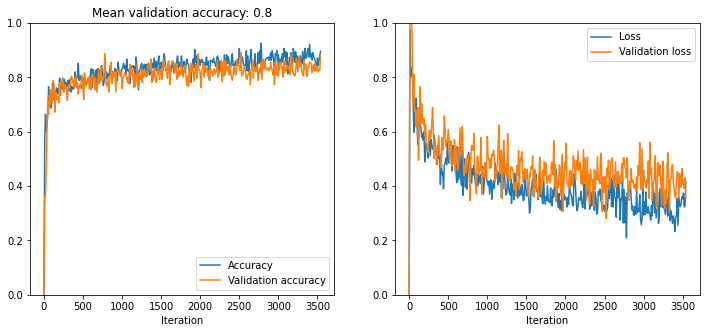

In [47]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
training_results.plot("Iteration", ["Accuracy", "Validation accuracy"], ax=axs[0], 
                    title="Mean validation accuracy: " + str(round(training_results["Validation accuracy"].mean(), 2)))
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[1])
axs[0].set_ylim(0, 1)
axs[1].set_ylim(0, 1)

In [48]:
truth, preds, losses = predict(resnet, test_data, 100, RES, DEVICE, return_loss=True)
confusion = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))
accuracy = accuracy_score(truth, preds, normalize=True)

100%|██████████| 90/90 [00:06<00:00, 14.02it/s]


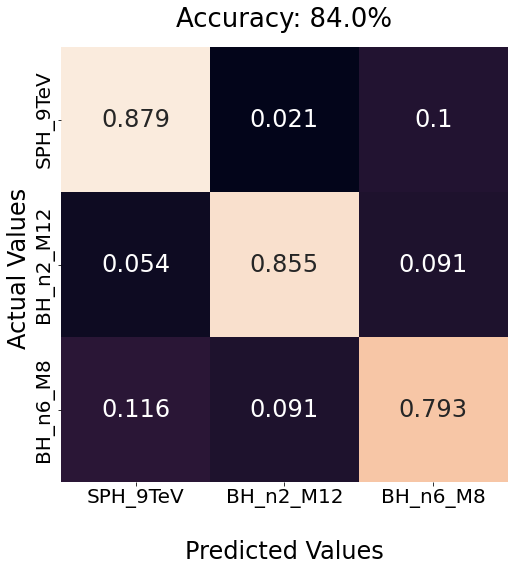

In [49]:
plot_conf_matrix(confusion, accuracy, PLOT_LABELS)

In [50]:
confusion["Event_ID"] = np.arange(0, len(confusion))
confusion["Correct_Pred"] = [confusion["Predictions"][i] == confusion["Truth"][i] for i in range(len(confusion))]
confusion["Losses"] = losses
#wrong_id = confusion[confusion["Correct_Pred"]==False]["Event_ID"].tolist()

In [51]:
confusion.sort_values(by=["Losses"], ascending=False, inplace=True, ignore_index=True)
confusion.sort_values(by=["Correct_Pred"], ascending=True, inplace=True, ignore_index=True)
print(confusion)

      Truth  Predictions  Event_ID  Correct_Pred    Losses
0       1.0          0.0      3833         False  0.455914
1       0.0          1.0      1574         False  0.521712
2       0.0          2.0      1573         False  0.521712
3       1.0          2.0      5029         False  0.254253
4       1.0          0.0      5028         False  0.254253
...     ...          ...       ...           ...       ...
8995    1.0          1.0      3692          True  0.422436
8996    1.0          1.0      3691          True  0.422436
8997    1.0          1.0      3690          True  0.422436
8998    1.0          1.0      3657          True  0.422436
8999    0.0          0.0       700          True  0.172923

[9000 rows x 5 columns]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Look at the highest histogram values values for a random image
[510.27994 573.61523 583.5406  653.37537 681.5569  709.6767  756.88556
 864.5289  927.46594]
Looking at image 3833


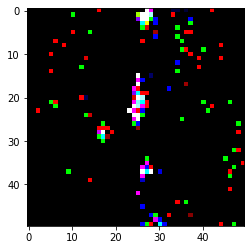

In [52]:
k = confusion["Event_ID"][0]
image = test_data[k][0].cpu()
print("Look at the highest histogram values values for a random image")
print(np.sort(image.flatten())[-10:-1])
print("Looking at image", k)

plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Look at the highest histogram values values for a random image
[ 266.75693  282.52023  398.0296   463.19968  489.1924   758.6404
  806.69135 1471.1718  1503.5322 ]
Looking at image 1574


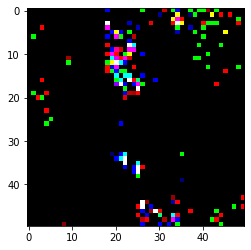

In [53]:
k = confusion["Event_ID"][1]
image = test_data[k][0].cpu()
print("Look at the highest histogram values values for a random image")
print(np.sort(image.flatten())[-10:-1])
print("Looking at image", k)

plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Look at the highest histogram values values for a random image
[ 333.68384  382.20538  393.18536  614.82837  674.1628   875.1459
  941.903   1103.5859  1492.6208 ]
Looking at image 1573


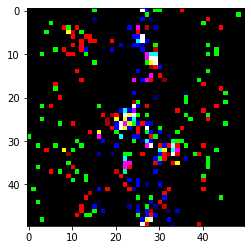

In [54]:
k = confusion["Event_ID"][2]
image = test_data[k][0].cpu()
print("Look at the highest histogram values values for a random image")
print(np.sort(image.flatten())[-10:-1])
print("Looking at image", k)

plt.imshow(image)